# QuICT Demo (circuit, simulator, qcda)

## Circuit

In [1]:
import numpy as np
from scipy.stats import unitary_group

# import circuit, gates
from QuICT.core import *

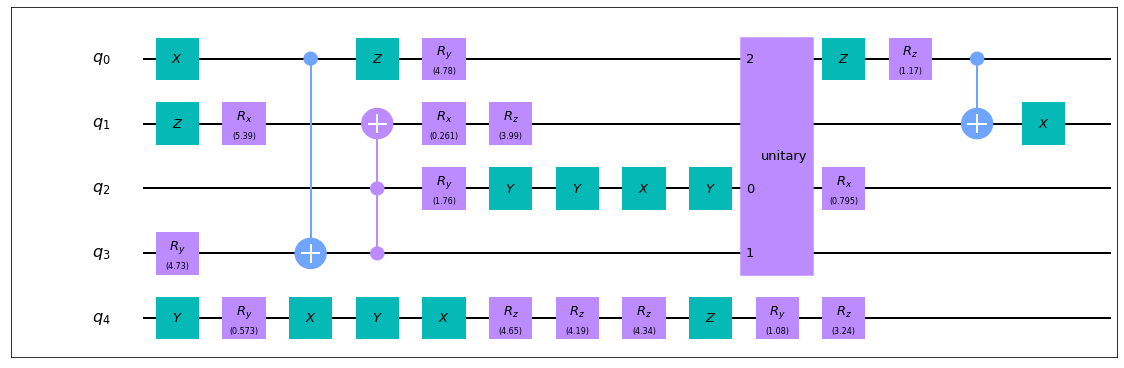

In [3]:
# build circuit with 5 quantum qubits
qubits = 5
cir = Circuit(qubits)

# append gates into circuit
gate_size = 10
typelist = [GATE_ID['Rx'], GATE_ID['Ry'], GATE_ID['Rz'], GATE_ID['X'], GATE_ID['Y'], GATE_ID['Z'], GATE_ID['CX']]
cir.random_append(gate_size, typeList=typelist)
target = random.sample(range(5), 3)
CCX | cir(target)
cir.random_append(gate_size, typeList=typelist)
matrix = unitary_group.rvs(2 ** 3)
target = random.sample(range(5), 3)
Unitary(matrix) | cir(target)
cir.random_append(gate_size, typeList=typelist)

cir.draw()

In [30]:
# show circuit info
def circuit_info(circuit):
    circuit_info = {
        "size": circuit.circuit_size(),
        "width": circuit.circuit_width(),
        "depth": circuit.circuit_depth(),
        "1-qubit_gates": circuit.circuit_count_1qubit(),
        "2-qubits_gates": circuit.circuit_count_2qubit(),
        "Swap_gates": circuit.circuit_count_gateType(Swap.type),
        "CNOT_gates": circuit.circuit_count_gateType(CX.type),
        "Toffoli_gates": circuit.circuit_count_gateType(CCX.type),
        "Unitary_gates": circuit.circuit_count_gateType(Unitary.type),
    }
    
    return circuit_info

In [32]:
circuit_info(cir)

{'size': 32,
 'width': 5,
 'depth': 13,
 '1-qubit_gates': 28,
 '2-qubits_gates': 2,
 'Swap_gates': 0,
 'CNOT_gates': 2,
 'Toffoli_gates': 1,
 'Unitary_gates': 1}

## Simulator

In [11]:
from QuICT.simulation.simulator import Simulator

In [13]:
simulator = Simulator(
    device="GPU",   # [CPU/GPU/qiskit/qcompute]
    backend="statevector",
    shots=10,
    optimize=True,
    precision='double',
    gpu_device_id=1,
    sync=True
)

result = simulator.run(cir)

result

{'id': '47f1e5c660a811ec9c0d2983f7ab120e',
 'mode': 'GPU-statevector',
 'shots': 10,
 'options': {'precision': 'double',
  'gpu_device_id': 1,
  'sync': True,
  'optimize': True},
 'counts': defaultdict(int,
             {'10110': 4,
              '11110': 1,
              '10111': 1,
              '01010': 1,
              '01110': 2,
              '10000': 1}),
 'output_path': '/home/likaiqi/Workplace/test/QuICT/example/demo/output'}

# qcda

In [23]:
from QuICT.core import Layout
from QuICT.qcda.qcda import QCDA
from QuICT.qcda.synthesis.gate_transform import IBMQSet, USTCSet

# Load layout
layout = Layout.load_file("../layout/ibmqx2.layout")
for edge in layout.edge_list:
    print(f"{edge.u} {edge.v}")

0 1
0 2
1 2
3 2
3 4
4 2


## Instruction set

Processing GateDecomposition
Process GateDecomposition finished
Processing GateTransform
Process GateTransform finished
Processing CommutativeOptimization
Process CommutativeOptimization finished


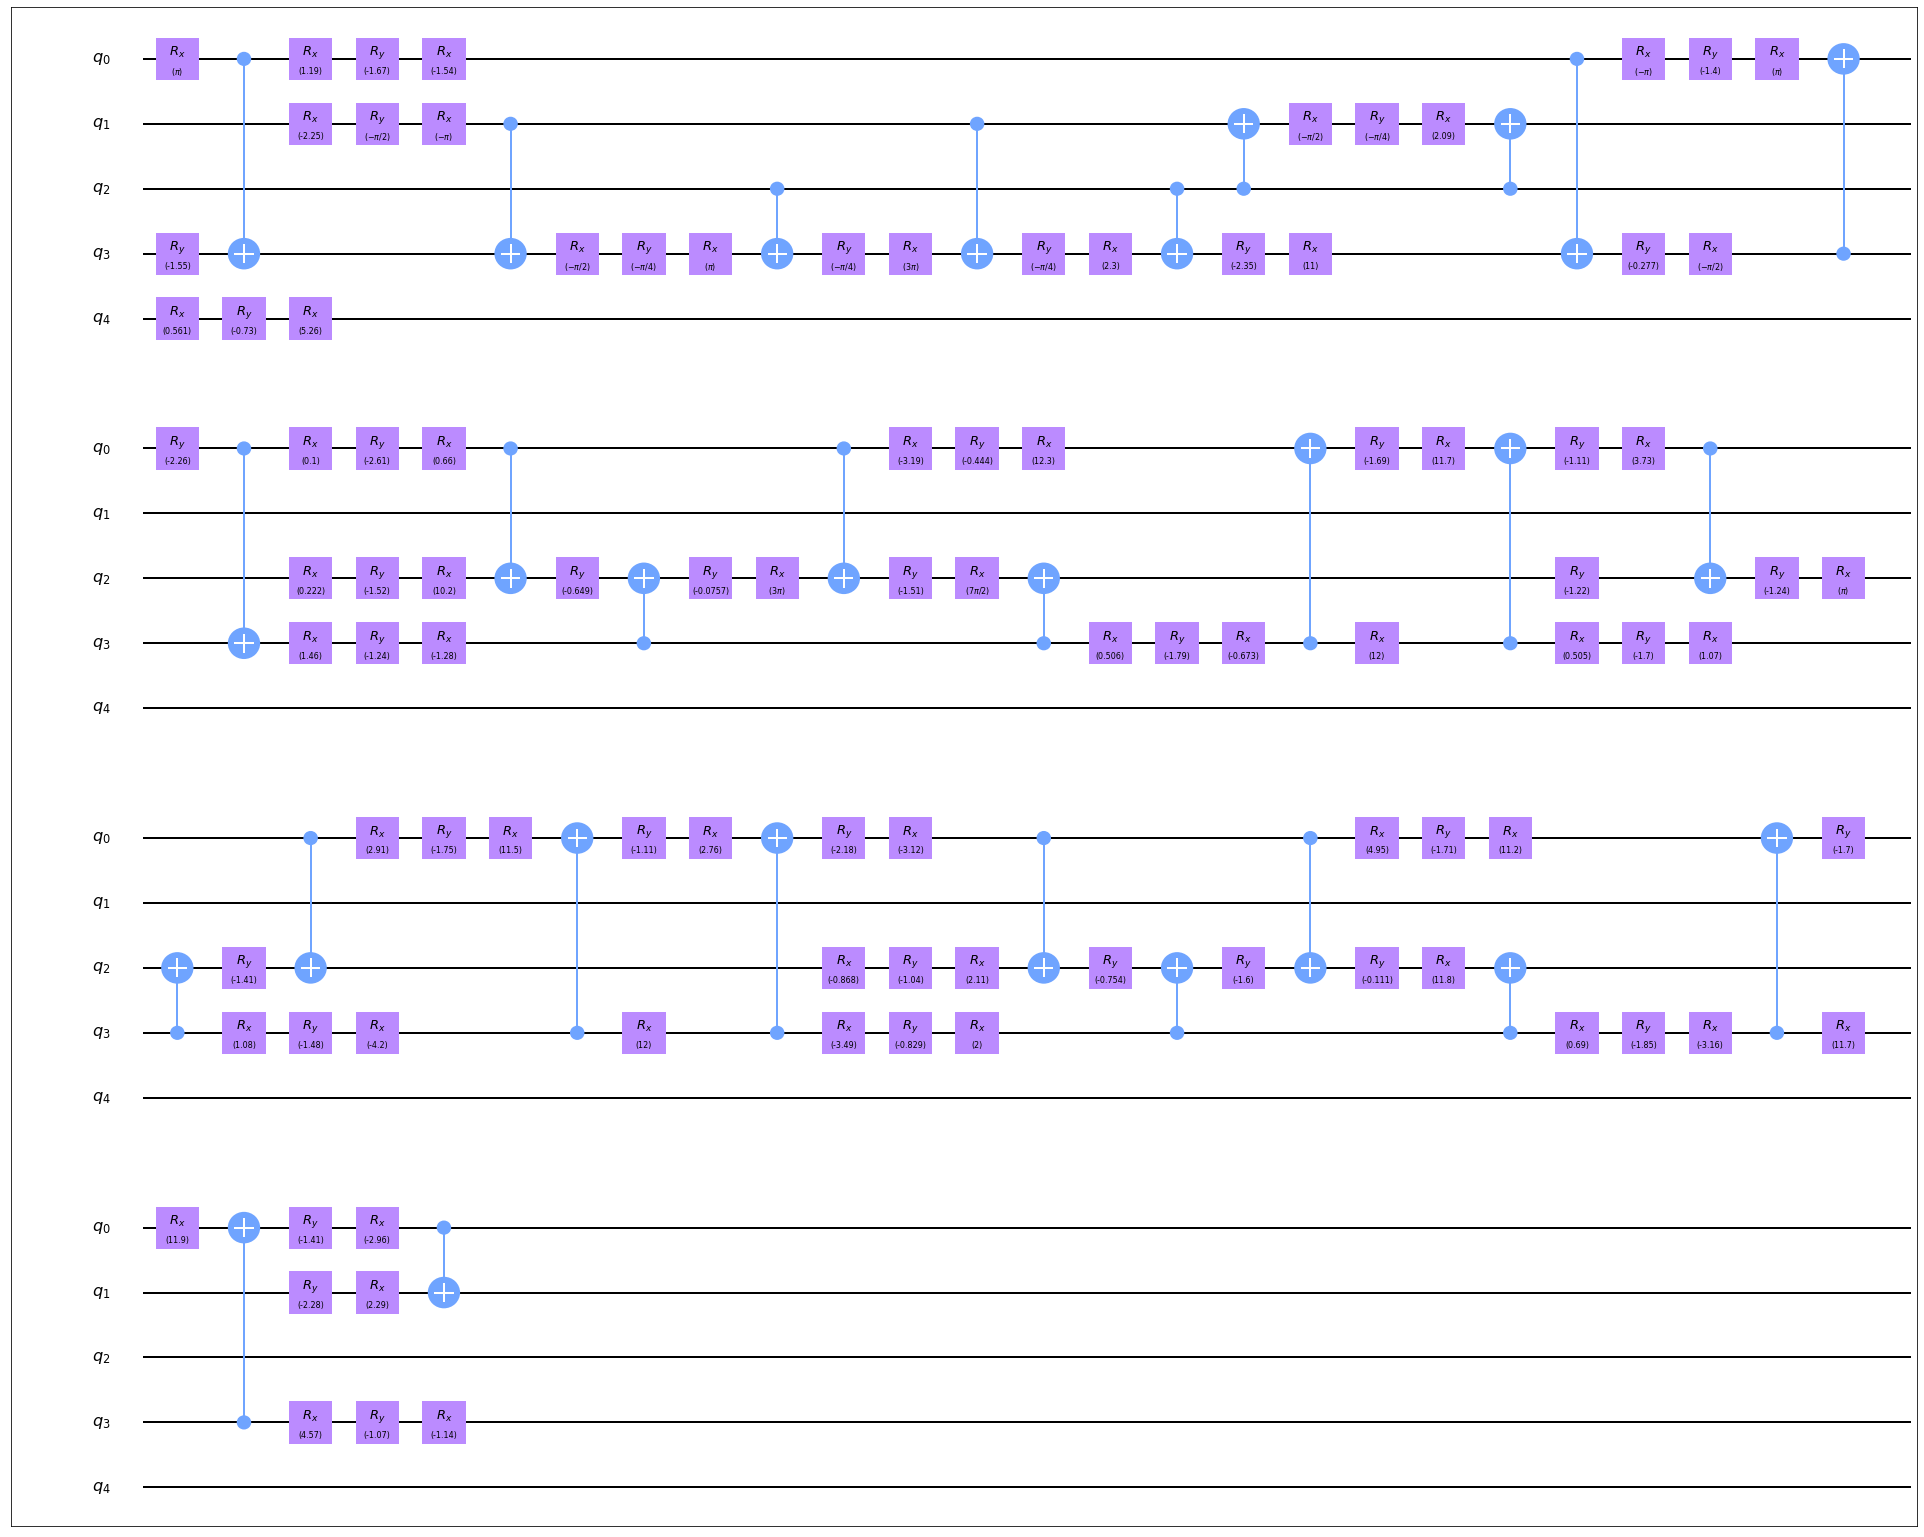

In [26]:
# Initial QCDA
qcda = QCDA()

# USTCSet: [CX, Rx, Ry, Rz, H, X]
cg_inst = qcda.compile(cir, USTCSet, mapping=False)
cir_inst = Circuit(5)
cg_inst | cir_inst
cir_inst.draw()

In [33]:
circuit_info(cir_inst)

{'size': 126,
 'width': 5,
 'depth': 77,
 '1-qubit_gates': 98,
 '2-qubits_gates': 28,
 'Swap_gates': 0,
 'CNOT_gates': 28,
 'Toffoli_gates': 0,
 'Unitary_gates': 0}

## mapping

Processing GateDecomposition
Process GateDecomposition finished
Processing GateTransform
Process GateTransform finished
Processing CommutativeOptimization
Process CommutativeOptimization finished
Processing CommutativeOptimization
Process CommutativeOptimization finished
Processing MCTSMapping
Process MCTSMapping finished


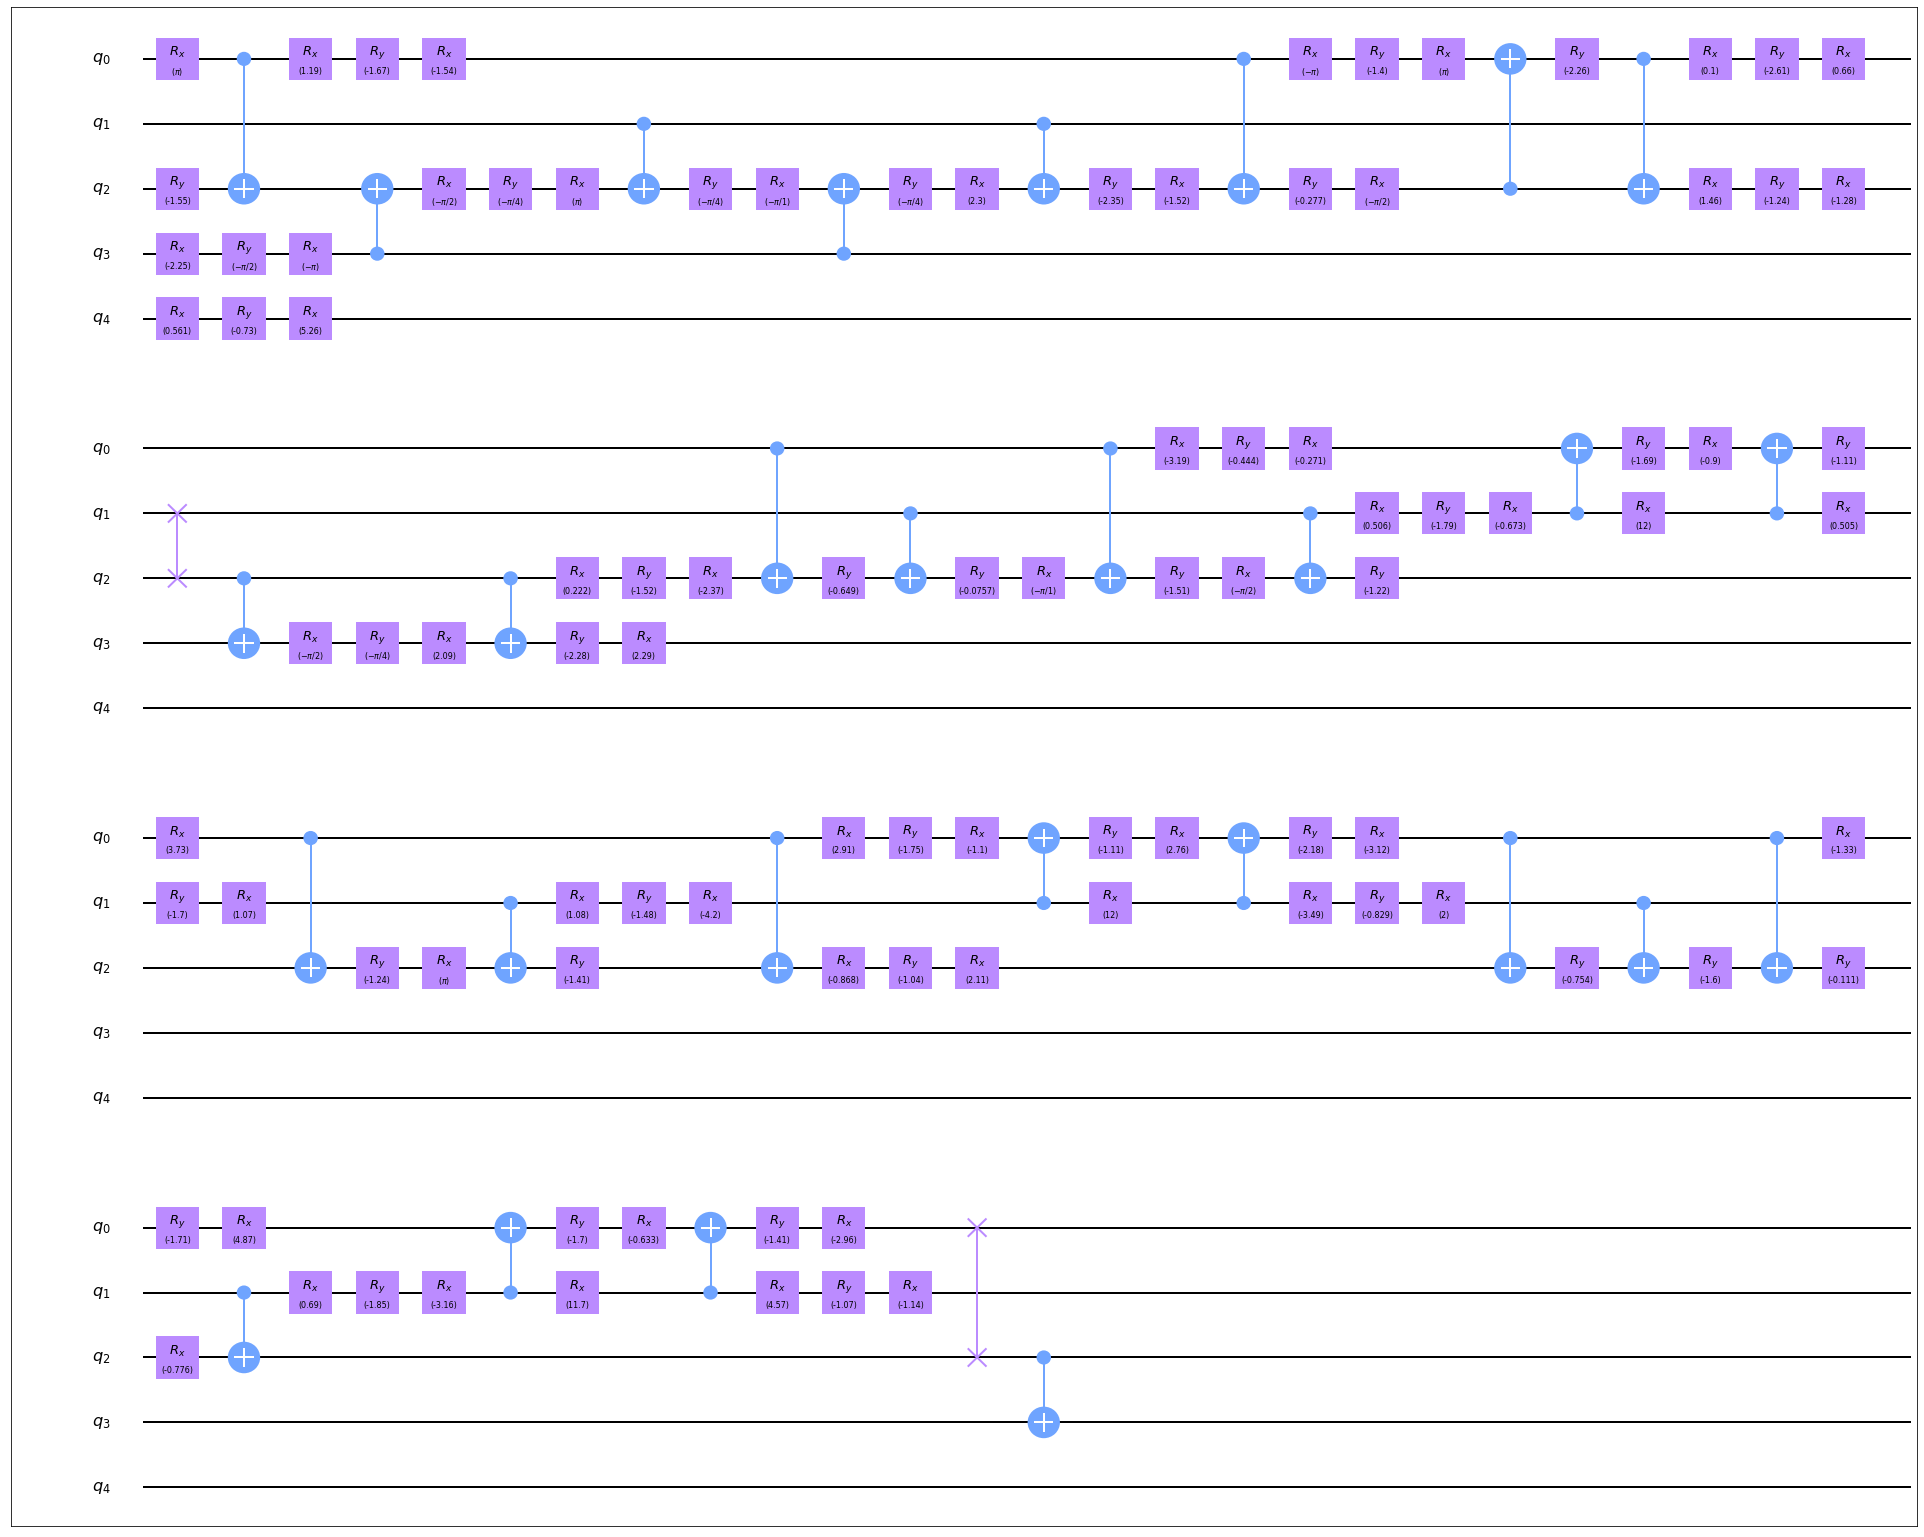

In [28]:
cir_mapping = qcda.compile(cir_inst, layout=layout, synthesis=False)
cir_mapping.draw()

In [34]:
circuit_info(cir_mapping)

{'size': 128,
 'width': 5,
 'depth': 87,
 '1-qubit_gates': 98,
 '2-qubits_gates': 30,
 'Swap_gates': 2,
 'CNOT_gates': 28,
 'Toffoli_gates': 0,
 'Unitary_gates': 0}

## QCDA - optimize

Processing GateDecomposition
Process GateDecomposition finished
Processing GateTransform
Process GateTransform finished
Processing CommutativeOptimization
Process CommutativeOptimization finished
Processing CommutativeOptimization
Process CommutativeOptimization finished
Processing MCTSMapping
Process MCTSMapping finished
Processing CommutativeOptimization
Process CommutativeOptimization finished
Processing CommutativeOptimization
Process CommutativeOptimization finished


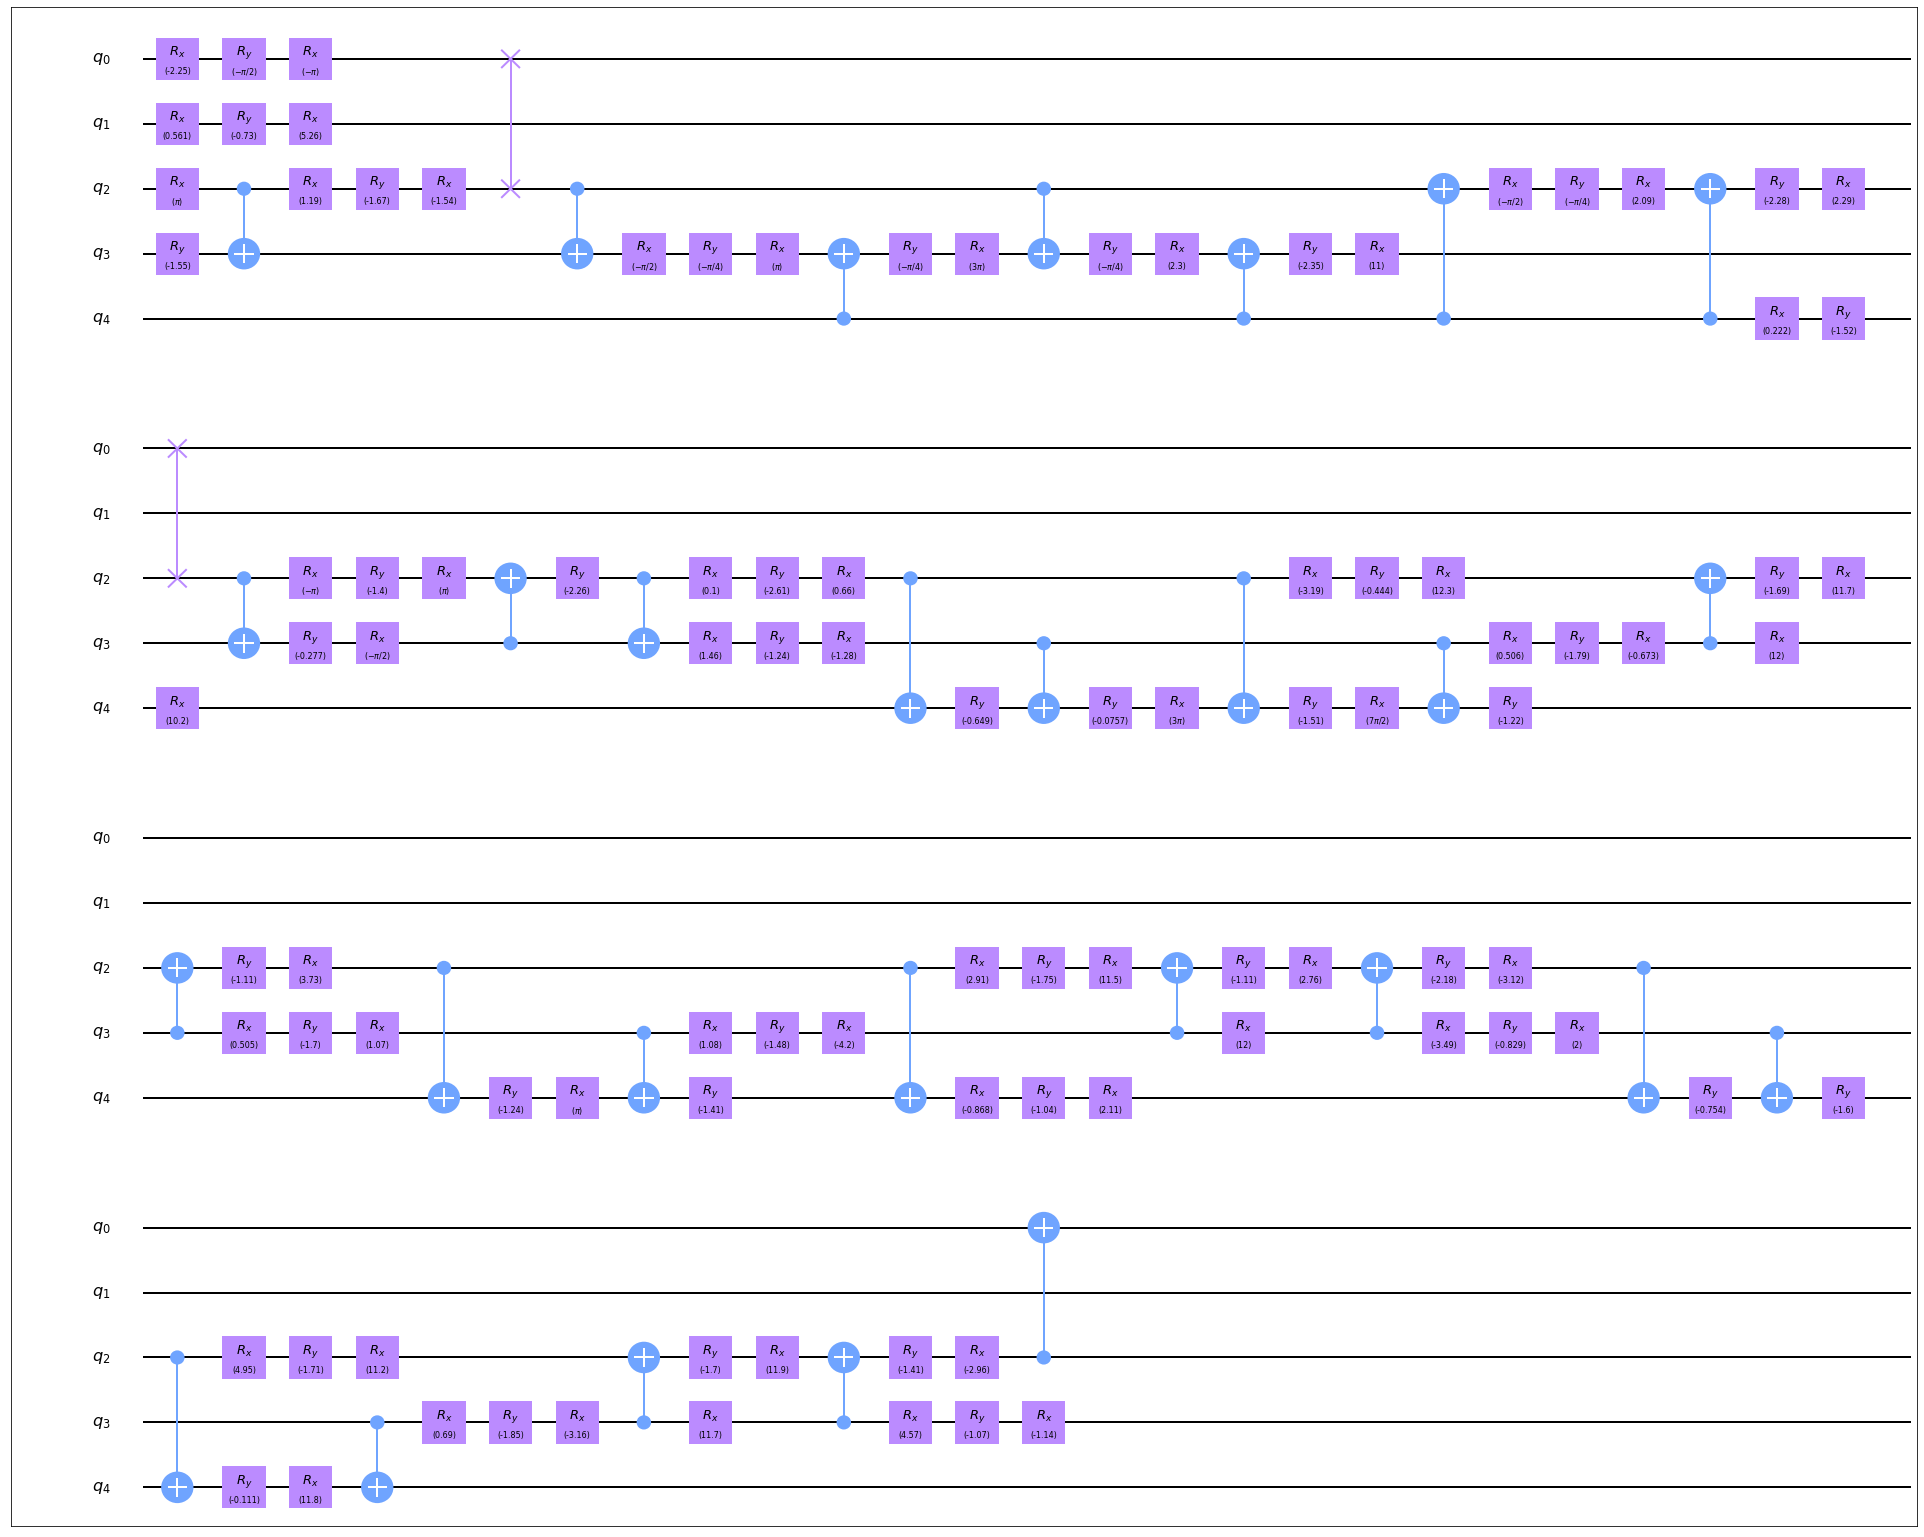

In [37]:
cg_opt = qcda.compile(cir, synthesis=False, optimization=True, mapping=False)
cir_opt = Circuit(5)
cg_opt | cir_opt
cir_opt.draw()

In [38]:
circuit_info(cir_opt)

{'size': 128,
 'width': 5,
 'depth': 86,
 '1-qubit_gates': 98,
 '2-qubits_gates': 30,
 'Swap_gates': 2,
 'CNOT_gates': 28,
 'Toffoli_gates': 0,
 'Unitary_gates': 0}

# CNOT Optimize